#### By: Peyman Shahidi
#### Created: Dec 16, 2025
#### Last Edit: Dec 16, 2025

<br>

In [1]:
#Python
import getpass
import numpy as np
import pandas as pd
from collections import defaultdict
import itertools
import random 

## formatting number to appear comma separated and with two digits after decimal: e.g, 1000 shown as 1,000.00
pd.set_option('float_format', "{:,.2f}".format)

import matplotlib.pyplot as plt
#%matplotlib inline
#from matplotlib.legend import Legend

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

In [2]:
main_folder_path = ".."
input_data_path = f"{main_folder_path}/data/computed_objects/tasks_sequences_robustness"
output_data_path = f'{input_data_path}/data/computed_objects/GPT_task_sequences_overlap_analysis'
output_plot_path = f"{main_folder_path}/writeup/plots"

In [3]:
# Create directories if they don't exist
import os

for path in [output_data_path, output_plot_path]:
    if not os.path.exists(path):
        os.makedirs(path)

### Main Code

In [4]:
from pathlib import Path
import pandas as pd
import re

base_dir = Path(input_data_path)

dfs = []

for folder in base_dir.iterdir():
    if not folder.is_dir():
        continue

    occupation = folder.name

    for csv_file in folder.glob("*.csv"):
        # Expect: <occupation>_X.csv
        match = re.search(rf"{re.escape(occupation)}_(\d+)\.csv$", csv_file.name)
        if match is None:
            continue  # skip files that don't match the convention

        prompt_number = int(match.group(1))

        df = pd.read_csv(csv_file)
        df["prompt_number"] = prompt_number

        dfs.append(df)

# Combine everything
master_df = pd.concat(dfs, ignore_index=True)

# Save if you want
# master_df.to_csv("masterfile.csv", index=False)


In [5]:
from scipy.stats import kendalltau
import itertools
import pandas as pd


def find_bad_prompts(df_occ):
    bad = (
        df_occ
        .groupby(["prompt_number", "Task ID"])
        .size()
        .reset_index(name="n")
        .query("n > 1")
        ["prompt_number"]
        .unique()
    )
    return set(bad)


def compute_pairwise_kendall_drop_bad(df_occ):

    bad_prompts = find_bad_prompts(df_occ)

    df_clean = df_occ[~df_occ["prompt_number"].isin(bad_prompts)]

    # need at least 2 prompts
    if df_clean["prompt_number"].nunique() < 2:
        return pd.DataFrame()

    rankings = {}

    for p, g in df_clean.groupby("prompt_number"):
        rankings[p] = (
            g.sort_values("Task Position")
             .set_index("Task ID")["Task Position"]
        )

    results = []

    for p1, p2 in itertools.combinations(rankings.keys(), 2):
        r1 = rankings[p1]
        r2 = rankings[p2]

        common_tasks = r1.index.intersection(r2.index)

        if len(common_tasks) < 2:
            continue

        tau, _ = kendalltau(
            r1.loc[common_tasks].values,
            r2.loc[common_tasks].values
        )

        results.append({
            "prompt_1": p1,
            "prompt_2": p2,
            "kendall_tau": tau
        })

    return pd.DataFrame(results)


all_results = []

for occ, df_occ in master_df.groupby("Detailed_Occupation_Title"):
    res = compute_pairwise_kendall_drop_bad(df_occ)
    if not res.empty:
        res["occupation"] = occ
        all_results.append(res)

kendall_results = pd.concat(all_results, ignore_index=True)
kendall_results

,prompt_1,prompt_2,kendall_tau,occupation
0,0,1,-0.14,Administrative Services Managers
1,0,2,0.57,Administrative Services Managers
2,0,3,0.36,Administrative Services Managers
3,0,4,0.36,Administrative Services Managers
4,0,5,0.50,Administrative Services Managers
...,...,...,...,...
3873,7,9,0.36,Zoologists and Wildlife Biologists
3874,7,10,0.34,Zoologists and Wildlife Biologists
3875,8,9,0.80,Zoologists and Wildlife Biologists
3876,8,10,0.65,Zoologists and Wildlife Biologists


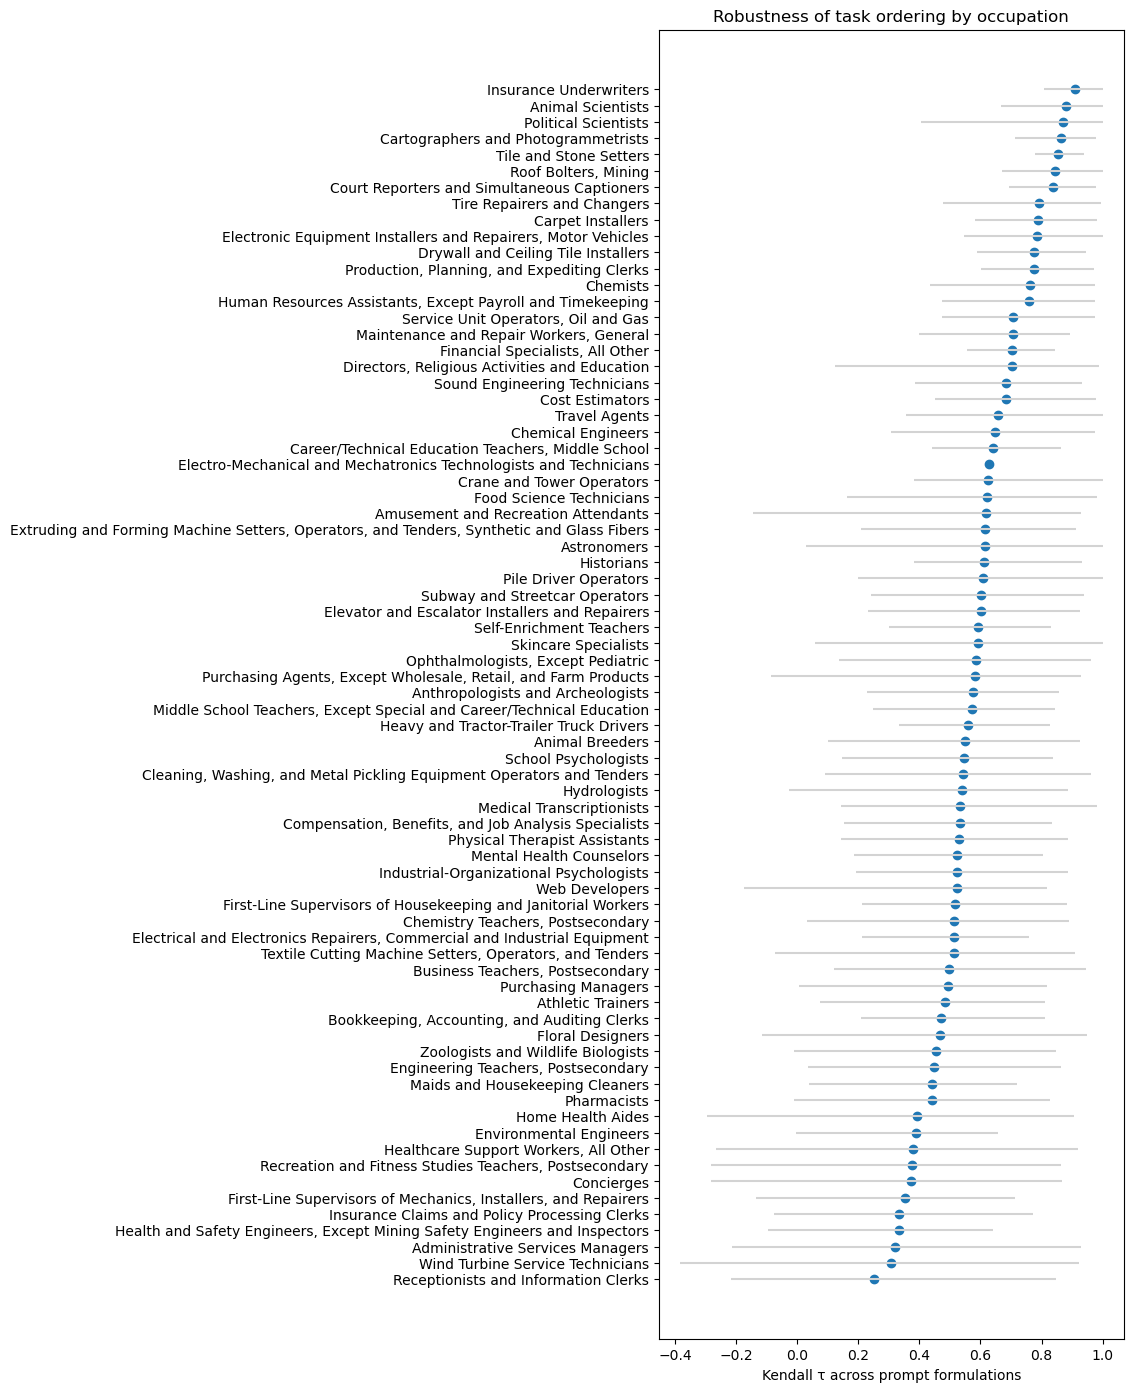

In [10]:
import matplotlib.pyplot as plt

summary = (
    kendall_results
    .groupby("occupation")["kendall_tau"]
    .agg(["mean", "min", "max"])
    .reset_index()
    .sort_values("mean")
)

plt.figure(figsize=(6, 17))
plt.hlines(
    y=summary["occupation"],
    xmin=summary["min"],
    xmax=summary["max"],
    color="lightgray"
)
plt.scatter(summary["mean"], summary["occupation"])
plt.xlabel("Kendall τ across prompt formulations")
plt.title("Robustness of task ordering by occupation")
plt.tight_layout()
plt.show()


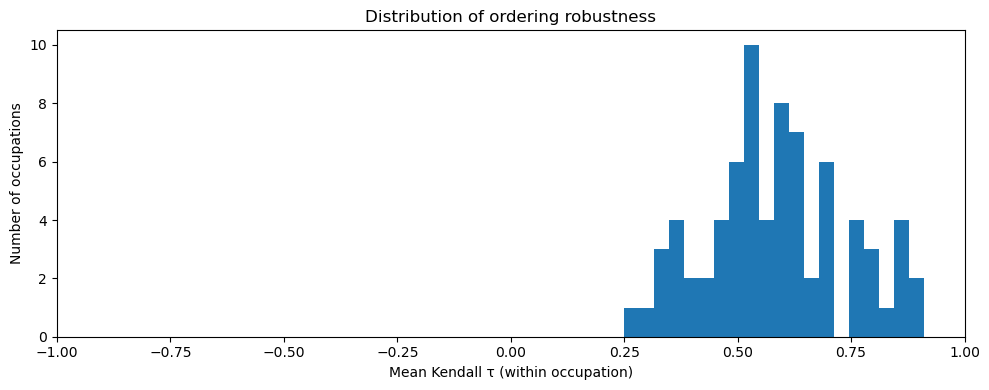

In [ ]:
plt.figure(figsize=(10, 4))
plt.hist(summary["mean"], bins=20)
plt.xlabel("Mean Kendall τ (within occupation)")
plt.ylabel("Number of occupations")
plt.title("Distribution of ordering robustness")
plt.xlim(-1, 1)
plt.tight_layout()
plt.show()